In [71]:
# Importing the necessary libraries and modules
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import util
import os
import scipy.stats as st

# Partial Connectivity

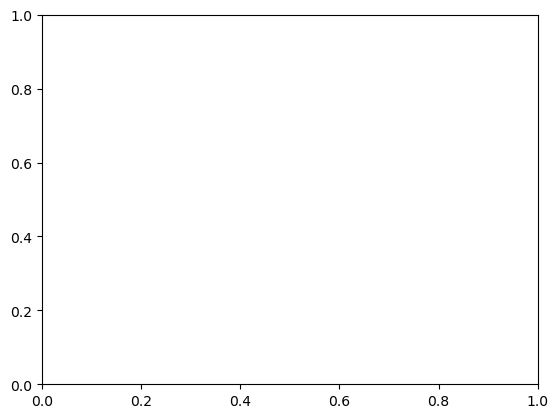

In [2]:
BAR_WIDTH= 0.75
BAR_DIST = 0.35
BASE = 1.7
GROUP_DIST = 10

TIMEOUTS = ["50ms","500ms","5000ms"]

fig, ax = plt.subplots()

In [107]:
CI_INIT = [(0,0) for _ in range(3)]

def get_empty_dict():
    all_bars = {
        'paxos_1min' : (np.zeros(3), CI_INIT),
        'raft_1min' : (np.zeros(3), CI_INIT),
        'raft_pvqc_1min' : (np.zeros(3), CI_INIT),
        'vr_1min' : (np.zeros(3), CI_INIT),
        'mp_1min' : (np.zeros(3), CI_INIT),

        'paxos_2min' : (np.zeros(3), CI_INIT),
        'raft_2min' : (np.zeros(3), CI_INIT),
        'raft_pvqc_2min' : (np.zeros(3), CI_INIT),
        'vr_2min' : (np.zeros(3), CI_INIT),
        'mp_2min' : (np.zeros(3), CI_INIT),

        'paxos_4min' : (np.zeros(3), CI_INIT),
        'raft_4min' : (np.zeros(3), CI_INIT),
        'raft_pvqc_4min' : (np.zeros(3), CI_INIT),
        'vr_4min' : (np.zeros(3), CI_INIT),
        'mp_4min' : (np.zeros(3), CI_INIT),
    }
    return all_bars

In [153]:
def get_timeout_idx(s):
    if s == '500ms':
        return 0
    elif s == '5000ms':
        return 1
    else:
        return 2
    
def get_dict_key(algo, scenario):
    split = scenario.split('-')
    duration = int(split[1])
    duration_min = int(duration/60)
    if algo == "mple":
        algo = "mp"
    elif algo == "raft_pv_qc":
        algo = "raft_pvqc"
    return "{}_{}min".format(algo, duration_min)

def student_t_ci(data):
    # create 95% confidence interval
    return st.t.interval(alpha=0.95, df=len(data)-1,loc=np.mean(data),scale=st.sem(data))



In [166]:
def read_dir(d, decided):
    all_bars = get_empty_dict()
    data_files = [f for f in os.listdir(d) if f.endswith('.data')]
    for filename in data_files :
        f = open(d + "/" + filename, 'r')
        print("Reading", filename, "...")
        # paxos,5,500,5min,off,none,constrained_election-240,500ms
        split = filename.split(',')
        algo = split[0]
        scenario = split[6]
        timeout = split[7]
        all_y = []
        for line in f:
            if decided:
                y = float(line.split('|')[1])
            else:
                y = float(line)
            all_y.append(y)
        mean = np.mean(all_y)
        ci = student_t_ci(all_y)
        timeout_idx = get_timeout_idx(timeout)
        bar_key = get_dict_key(algo, scenario)

        (all_mean, all_ci) = all_bars[bar_key]
        all_mean[timeout_idx] = mean
        all_ci[timeout_idx] = ci
        
    all_1min = [("Omni-Paxos", all_bars['paxos_1min']), ("Raft", all_bars['raft_1min']), ("Raft PV+CQ", all_bars['raft_pvqc_1min']), ("VR", all_bars['vr_1min']), ("Multi-Paxos", all_bars['mp_1min'])]
    all_2min = [("Omni-Paxos", all_bars['paxos_2min']), ("Raft", all_bars['raft_2min']), ("Raft PV+CQ", all_bars['raft_pvqc_2min']), ("VR", all_bars['vr_2min']), ("Multi-Paxos", all_bars['mp_2min'])]
    all_4min = [("Omni-Paxos", all_bars['paxos_4min']), ("Raft", all_bars['raft_4min']), ("Raft PV+CQ", all_bars['raft_pvqc_4min']), ("VR", all_bars['vr_4min']), ("Multi-Paxos", all_bars['mp_4min'])]
    if decided:
        all_groups = [("1 min", all_1min),("2 min", all_2min),("4 min", all_4min)]
    else:
        all_groups = [all_1min, all_2min, all_4min]
    return all_groups

In [167]:
def plot_all_bars(all_groups):
    for k in range(len(all_groups)):
        group_base = (k+1) * GROUP_DIST
        group = all_groups[k]
        for i in range(len(group)):
            (algo, (algo_group, ci)) = group[i]
            base = group_base + (i+1)*BASE
            algo_group_len = len(algo_group)
            for j in range(algo_group_len):
                timeout = TIMEOUTS[algo_group_len - j-1]
                label = "{} {}".format(algo, timeout)
                bar_dist = (algo_group_len - j)*BAR_DIST
                y = algo_group[algo_group_len - j - 1]/1000
                #bar_dist = (j)*BAR_DIST
                #y = algo_group[j]
                x = base + bar_dist
                #print("x: {}, y: {}".format(x, y))
                error_bar_color = "black"
                if util.colors[label] == "black":
                    error_bar_color = "gray"
                #print(ci[algo_group_len - j-1])
                (ci_lo, ci_hi) = ci[algo_group_len - j-1]
                if y > 0:
                    plt.bar(x, y, align='edge', width=BAR_WIDTH, color=util.colors[label], alpha=0.95, yerr=(ci_hi/1000-ci_lo/1000)/2, ecolor = error_bar_color, error_kw = {"elinewidth": 3.5})

    #plt.yscale("log")
    SIZE = 20
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    # Deadlock line
    plt.axhline(y = 40, color = 'r', linestyle = '--')

    x_ticks = [15.5, 25.5, 35.5]
    x_labels = ["1 min", "2 min", "4 min"]
    plt.xticks(x_ticks, x_labels)
    plt.tick_params(axis='both', which='major', labelsize=SIZE)
    plt.ylabel("Down-time (s)", size=20)
    plt.xlabel("Partition Duration", size=20)
    plt.ylim(top=40)


#ax.legend(fontsize=18)
#fig = ax.get_figure()
#fig.set_size_inches(8.5, 4.5)

In [177]:
UNIT = 1000000

def plot_all_chained(all_groups):
    x_ticks = []
    x_labels = []
    for k in range(len(all_groups)):
        group_base = (k+1) * GROUP_DIST
        (partition_duration, group) = all_groups[k]
        for i in range(len(group)):
            (algo, (algo_group, ci)) = group[i]
            base = group_base % len(group) + (i+1)*BASE
            algo_group_len = len(algo_group)
            for j in range(algo_group_len):
                timeout = TIMEOUTS[j]
                label = "{} {}".format(algo, timeout)
                bar_dist = (j)*BAR_DIST
                y = algo_group[j]
                #bar_dist = (j)*BAR_DIST
                #y = algo_group[j]
                x = base + bar_dist
                #print("x: {}, y: {}".format(x, y))
                #plt.bar(x, y, align='edge', width=BAR_WIDTH, color=util.colors[label], alpha=0.95, yerr = ci[algo_group_len - j-1]/1000, ecolor = error_bar_color, error_kw = {"elinewidth": 3.5})
                (ci_lo, ci_hi) = ci[j]
                if y > 0:
                    plt.errorbar(x, y/UNIT, yerr = (ci_hi/UNIT-ci_lo/UNIT)/2, color=util.colors[label], elinewidth=3, zorder=1)
                    plt.scatter(x, y/UNIT, color=util.colors[label], s=130, zorder=2, marker=util.markers[partition_duration], edgecolors="black")
                if j == 1:
                    x_ticks.append(x)
                    x_labels.append(algo)
                    
    SIZE = 20
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels

    plt.xticks(x_ticks, x_labels)
    plt.tick_params(axis='both', which='major', labelsize=SIZE)
    plt.ylabel("Number of Decided (million ops)", size=20)

## Constrained Scenario

Reading paxos,5,500,5min,off,none,constrained_election-120,50ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-60,50ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-120,500ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-60,5000ms.data ...
Reading paxos,5,500,5min,off,none,constrained_election-240,500ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-120,50ms.data ...
Reading paxos,5,500,5min,off,none,constrained_election-60,50ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-120,5000ms.data ...
Reading paxos,5,500,5min,off,none,constrained_election-240,5000ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-240,5000ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-240,500ms.data ...
Reading paxos,5,500,5min,off,none,constrained_election-240,50ms.data ...
Reading mple,5,500,5min,off,none,constrained_election-240,50ms.data ...
Reading mple,5,500,5min,off,none,constrained_electi

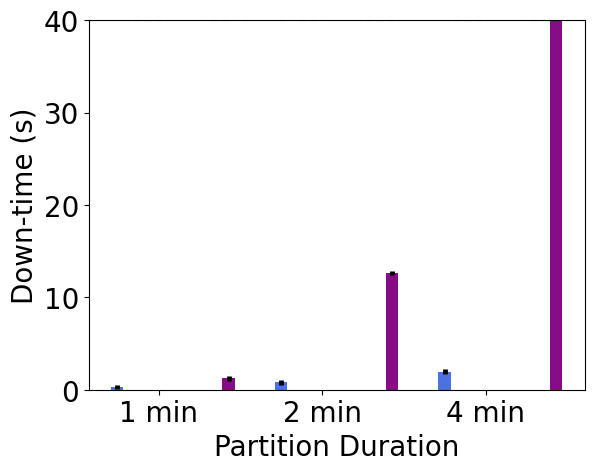

In [168]:
CONSTRAINED_DIR = "/Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/oct-15/constrained/meta_results/constrained-paxos-mple-part1/5-500-off/longest_down_time"
all_constrained = read_dir(CONSTRAINED_DIR, False)
plot_all_bars(all_constrained)

## Quorum-loss Scenario

In [ ]:
QUORUMLOSS_DIR = #TODO
all_quorumloss = read_dir(QUORUMLOSS_DIR, False)
plot_all_bars(all_quorumloss)

## Chained Scenario

Reading raft,3,500,5min,off,none,chained-240,5000ms.data ...
Reading raft_pv_qc,3,500,5min,off,none,chained-240,50ms.data ...
Reading raft,3,500,5min,off,none,chained-240,50ms.data ...
Reading raft,3,500,5min,off,none,chained-240,500ms.data ...
Reading mple,3,500,5min,off,none,chained-240,50ms.data ...
Reading mple,3,500,5min,off,none,chained-240,5000ms.data ...
Reading raft_pv_qc,3,500,5min,off,none,chained-240,5000ms.data ...
Reading mple,3,500,5min,off,none,chained-240,500ms.data ...
Reading raft_pv_qc,3,500,5min,off,none,chained-240,500ms.data ...


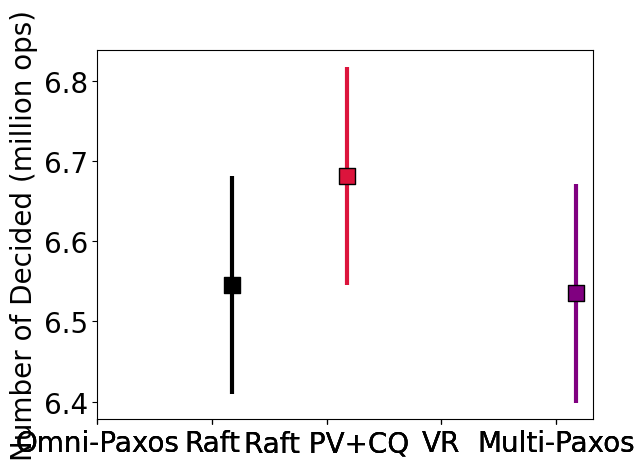

In [178]:
CHAINED_DIR = "/Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/oct-15/chained/meta_results/chained-mple-raft-part1/3-500-off/num_decided"
all_chained = read_dir(CHAINED_DIR, True)
plot_all_chained(all_chained)

# Steady State

In [276]:
def get_empty_dict_normal():
    return {
        'Omni-Paxos, n=3' : (np.zeros(3), np.zeros(3)),
        'Raft, n=3' : (np.zeros(3), np.zeros(3)),
        'Multi-Paxos, n=3' : (np.zeros(3), np.zeros(3)),
        
        'Omni-Paxos, n=5' : (np.zeros(3), np.zeros(3)),
        'Raft, n=5' : (np.zeros(3), np.zeros(3)),
        'Multi-Paxos, n=5' : (np.zeros(3), np.zeros(3)),
    }

def get_cp_idx(cp):
    if cp == 500:
        return 0
    elif cp == 5000:
        return 1
    else:
        return 2
    
def get_dict_key_normal(algo, num_nodes):
    print(algo, num_nodes)
    if algo == "paxos":
        algo = "Omni-Paxos"
    elif algo == "mp" or algo == "mple":
        algo = "Multi-Paxos"
    elif algo == "raft" or algo == "raft_pvqc":
        algo = "Raft"
    return "{}, n={}".format(algo, num_nodes)    

In [277]:
EXP_DURATION = 5 * 60

def to_tp(num_proposals):
    return num_proposals/EXP_DURATION

def ci_to_err_tp(ci):
    (lo, hi) = ci
    (lo_tp, hi_tp) = (to_tp(hi), to_tp(lo))
    err = (hi_tp-lo_tp)/2
    return err

In [281]:
def read_normal_dir(p):
    all_series = get_empty_dict_normal()
    directories = [f.path for f in os.scandir(p) if f.is_dir()]
    for d in directories:
        decided_path = "{}/num_decided".format(d)
        data_files = [f for f in os.listdir(decided_path) if f.endswith('.data')]
        for filename in data_files:
            f = open(decided_path + "/" + filename, 'r')
            print("Reading", filename, "...")
            # paxos,5,500,5min,off,none,constrained_election-240,500ms
            dir_split = filename.split(',')
            algo = dir_split[0]            
            num_nodes = int(dir_split[1])
            num_cp = int(dir_split[2])
            all_y = []
            for line in f:
                num_decided = float(line.split('|')[1])
                y = to_tp(num_decided)
                all_y.append(y)
            mean = np.mean(all_y)
            ci_decided = student_t_ci(all_y)
            ci = ci_to_err_tp(ci_decided)
            cp_idx = get_cp_idx(num_cp)
            dict_key = get_dict_key_normal(algo, num_nodes)
            print(dict_key)

            (all_mean, all_ci) = all_series[dict_key]
            all_mean[cp_idx] = mean
            all_ci[cp_idx] = ci
        
    return all_series

In [282]:
x_axis = [1, 2, 3]
num_cp = ["500", "5k", "50k"]

def plot_normal(all_series):
    for (label, (data, ci)) in all_series.items():
        if all(data > 0):
            print(label)
            color = util.colors[label]
            split = label.split(",")
            linestyle = util.linestyles[split[0]]
            marker = util.markers[split[1]]
            plt.errorbar(x_axis, data, label=label, color=color, marker=marker, linestyle=linestyle, yerr=ci, capsize=8)
        
    plt.xticks(x_axis, num_cp)
    #plt.yticks(np.arange(0, 175000, 25000).tolist())
    #ax.set_ylim(bottom=0)


Reading paxos,3,500,5min,off,none,fully_connected,30000ms.data ...
paxos 3
Omni-Paxos, n=3
Reading raft,3,500,5min,off,none,fully_connected,30000ms.data ...
raft 3
Raft, n=3
Reading raft,3,50000,5min,off,none,fully_connected,30000ms.data ...
raft 3
Raft, n=3
Reading paxos,3,50000,5min,off,none,fully_connected,30000ms.data ...
paxos 3
Omni-Paxos, n=3
Reading raft,3,5000,5min,off,none,fully_connected,30000ms.data ...
raft 3
Raft, n=3
Reading paxos,3,5000,5min,off,none,fully_connected,30000ms.data ...
paxos 3
Omni-Paxos, n=3
Omni-Paxos, n=3
Raft, n=3


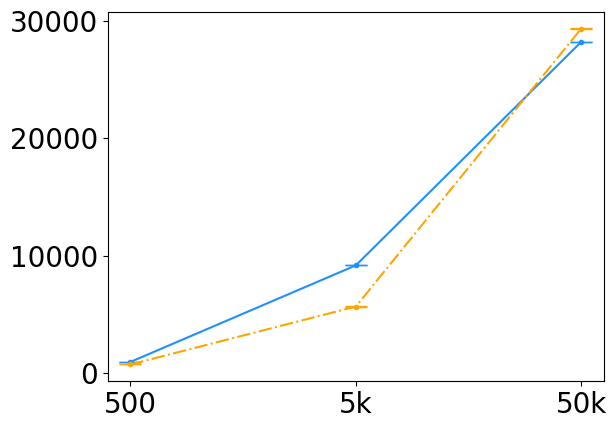

In [283]:
NORMAL_DIR = "/Users/haraldng/Library/CloudStorage/Dropbox/google-cloud/revision/oct-15/full-wan/paxosraft-fullwan-part1"
all_series = read_normal_dir(NORMAL_DIR)
plot_normal(all_series)
